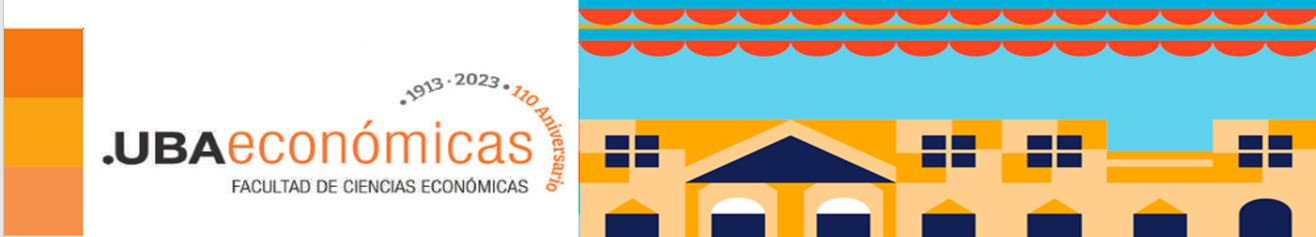

**GESTIÓN DE DATOS EN ORGANIZACIONES - 2DO ENCUENTRO INTERDISCIPLINAR**

**El arte de predecir: Forecasting de Series Temporales mediante Machine Learning en Python**

Rodrigo Del Rosso

# Script 1 - LightGBM


**Modelos Ensambles**   

Los modelos de Gradient Boosting, como XGBoost y LightGBM, han demostrado su eficacia en una amplia gama de aplicaciones de aprendizaje automático, desde clasificación hasta regresión. Sin embargo, una de las áreas más desafiantes y emocionantes en las que estos algoritmos han encontrado aplicabilidad es en la predicción de series de tiempo. La adaptación de estos modelos al dominio de series temporales es esencial, ya que las características únicas de este tipo de datos, como la dependencia temporal y la estacionalidad, requieren un enfoque especializado. En esta introducción, exploraremos cómo se aplican y adaptan los modelos de aumento de gradiente para abordar problemas de predicción de series de tiempo.

¿Qué es el Boosting? Boosting es una técnica conjunta de aprendizaje automático que combina múltiples modelos débiles (weak models) en un único modelo fuerte. En Boosting, cada modelo aprende de los errores del modelo anterior, lo que da como resultado un modelo mejor en general. El objetivo es mejorar la precisión de un modelo reduciendo la varianza y el sesgo en los datos. Boosting es una técnica popular para resolver problemas de clasificación y regresión.

Las principales diferencias de LightGBM frente a XGBoost es su estrategia de crecimiento de árboles en forma de hojas, su técnica exclusiva de agrupación de funciones y su menor consumo de memoria.

Queremos predecir el consumo futuro.  

Documentación: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

Carga de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')
#plt.style.use('fivethirtyeight')
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Carga y Procesamiento inicial del dataset

In [2]:
URL='https://raw.githubusercontent.com/rodrigodelrosso/Taller-Datos/main/consumo.csv'
df = pd.read_csv(URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [3]:
df['Datetime'].dtype

dtype('O')

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')


In [5]:
df = df.set_index('Datetime') # Ponemos a 'Datetime' como el índice del DataFrame
df.sort_index(inplace=True) # orden cronologico
print(df.shape)
df.head()

(145366, 1)


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [6]:
df.tail(5)

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


Los datos tienen una frecuencia de registro cada 1 hora

**Visualizamos la serie:**

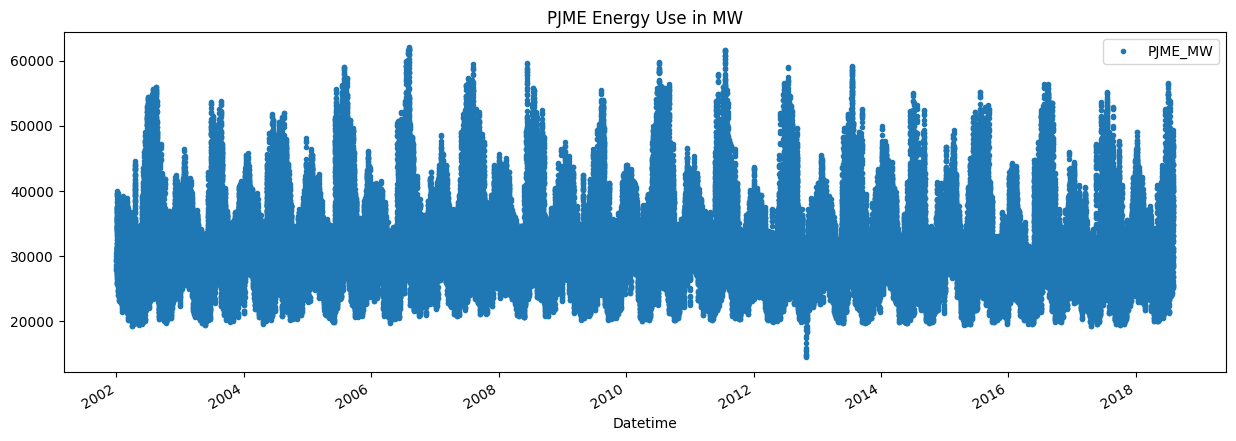

In [7]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

Que observamos en la gráfica?

Valores faltantes

In [8]:
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna PJME_MW: 0


In [9]:
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


Analisis de outliers

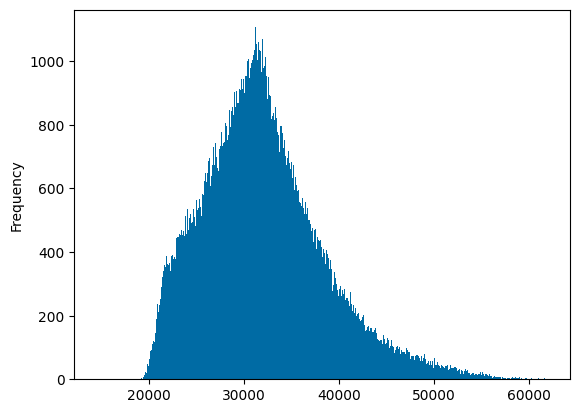

In [10]:
df['PJME_MW'].plot(kind='hist', bins=500);

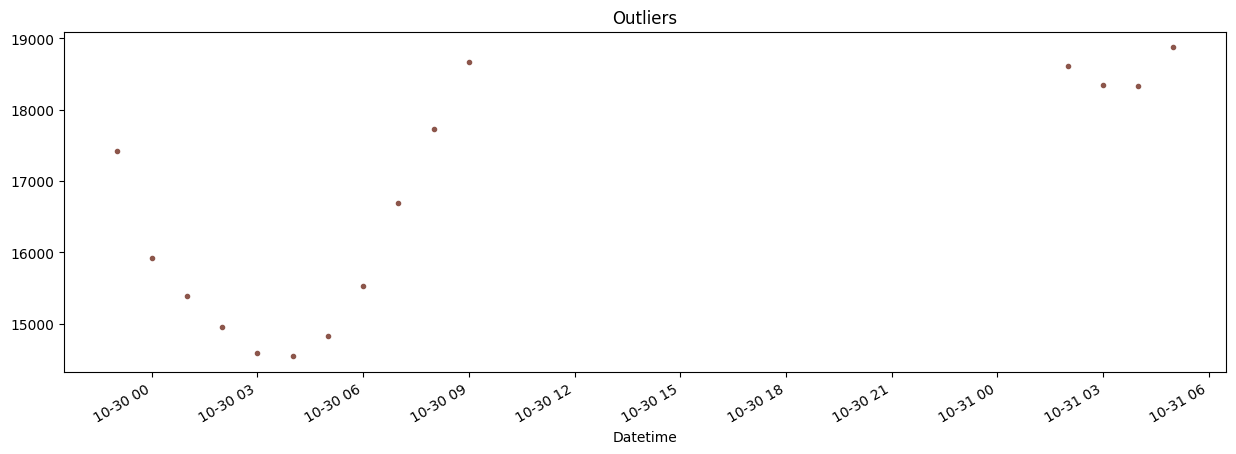

In [11]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',figsize=(15, 5), color=color_pal[5],title='Outliers');

Se genera un array de números aleatorios uniformemente distribuidos entre 19000 y 20000.

In [12]:
condicion = df['PJME_MW'] < 19000
df.loc[condicion, 'PJME_MW'] = np.random.uniform(19000, 20000, condicion.sum())

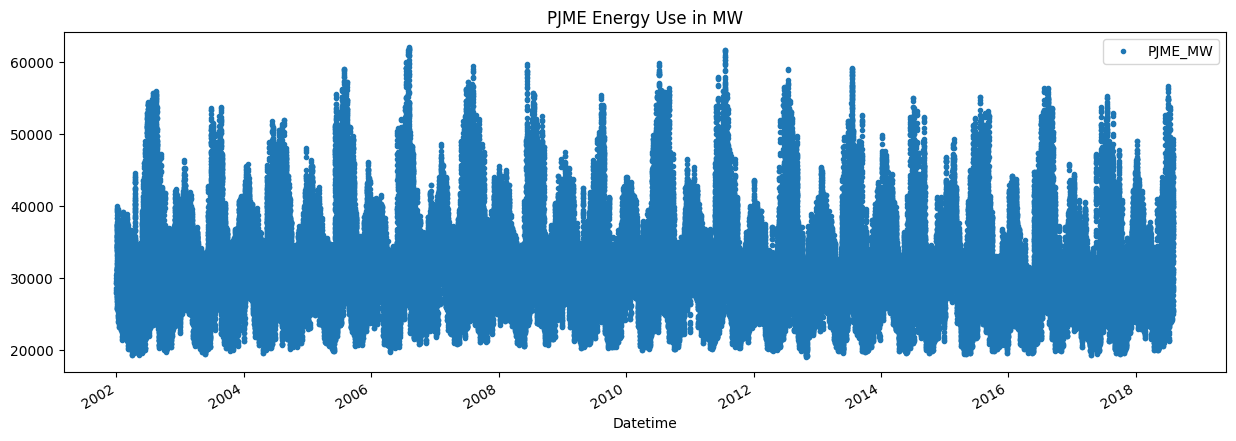

In [13]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

Separamos train y test

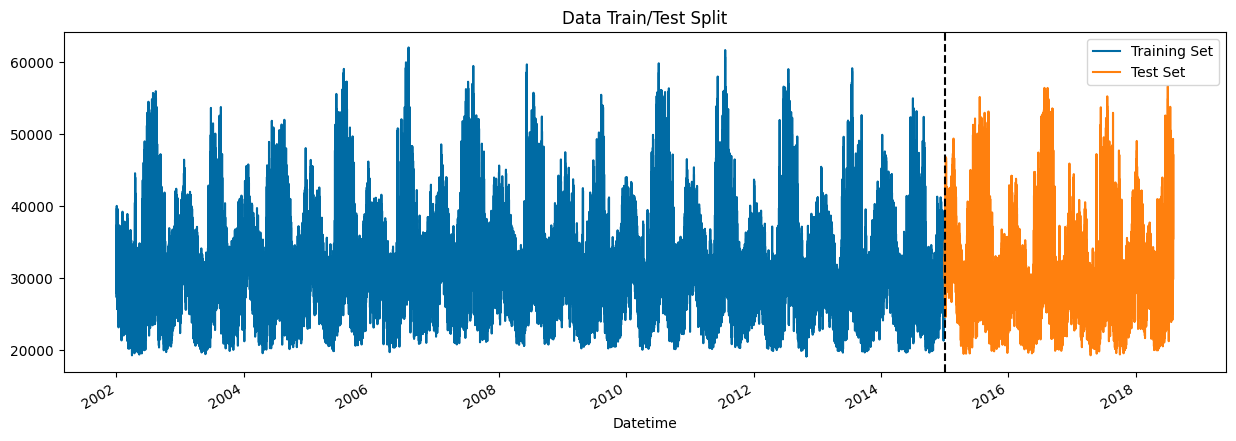

In [14]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Cross Validation para Series de Tiempo**

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

La siguiente línea de código crea un objeto de tipo TimeSeriesSplit que se utiliza para dividir una serie temporal en conjuntos de entrenamiento y prueba para su validación cruzada.

n_splits=5: Indica que se dividirá la serie temporal en 5 conjuntos diferentes  

Gap: se asegura que el conjunto de prueba refleje mejor una situación en la que solo se tiene información hasta un cierto punto en el tiempo, y el modelo debe hacer predicciones futuras basadas en ese conocimiento limitado.

In [15]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index() # ordena las filas del DataFrame df según los valores del índice

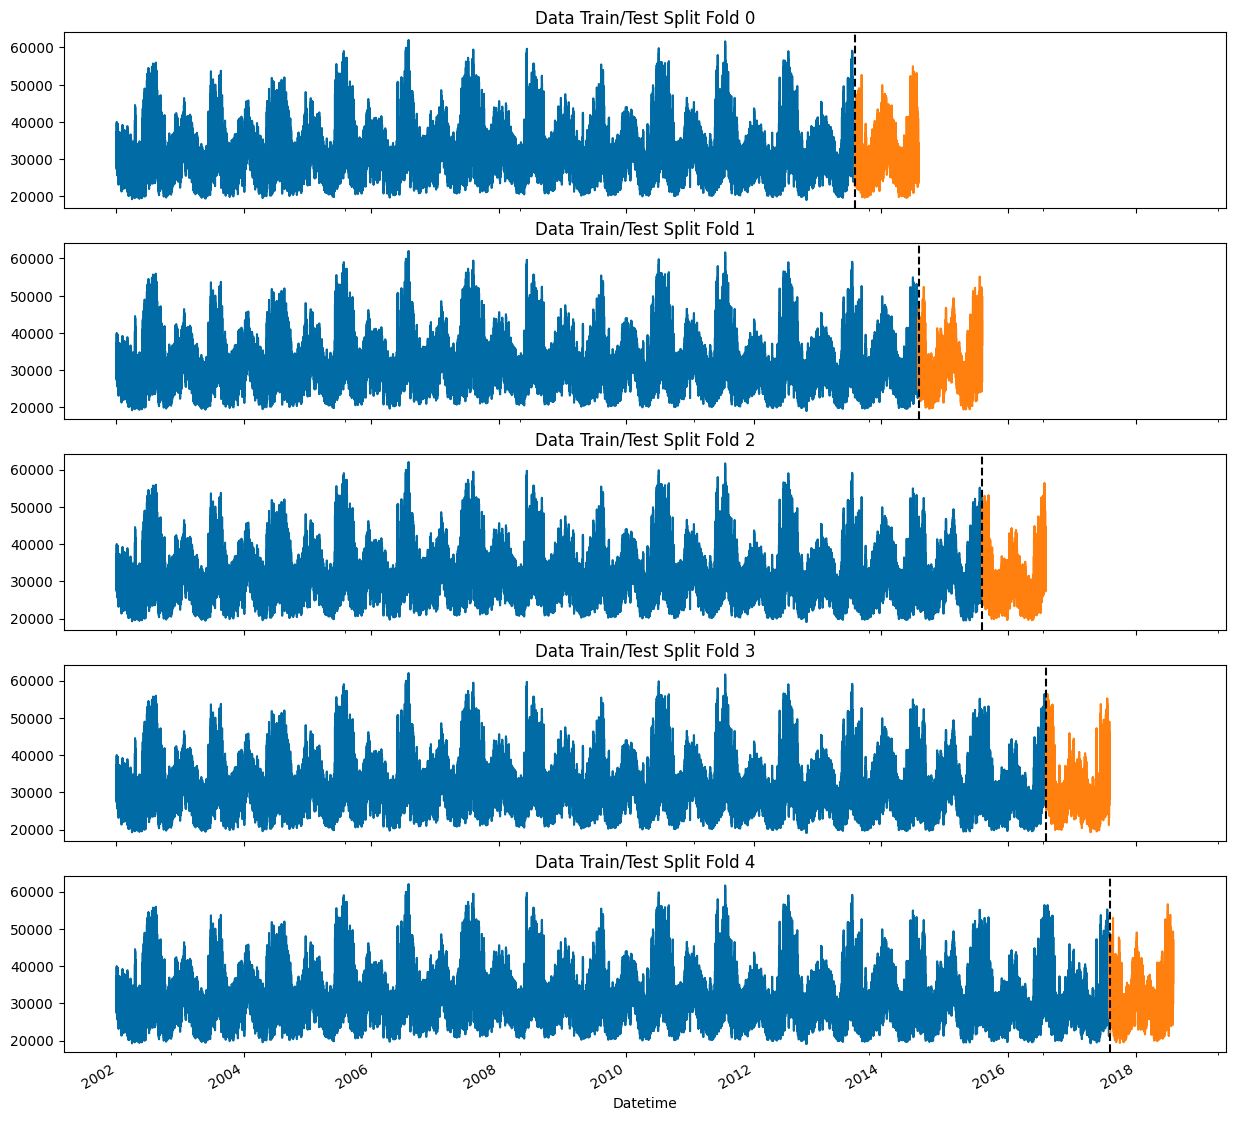

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['PJME_MW'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Visualizamos la estructura de tss

In [17]:
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

Aca hacemos una cross validation, teniendo en cuenta el orden temporal de los datos

In [18]:
for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[     0      1      2 ... 101539 101540 101541]
  Test:  index=[101566 101567 101568 ... 110323 110324 110325]
Fold 1:
  Train: index=[     0      1      2 ... 110299 110300 110301]
  Test:  index=[110326 110327 110328 ... 119083 119084 119085]
Fold 2:
  Train: index=[     0      1      2 ... 119059 119060 119061]
  Test:  index=[119086 119087 119088 ... 127843 127844 127845]
Fold 3:
  Train: index=[     0      1      2 ... 127819 127820 127821]
  Test:  index=[127846 127847 127848 ... 136603 136604 136605]
Fold 4:
  Train: index=[     0      1      2 ... 136579 136580 136581]
  Test:  index=[136606 136607 136608 ... 145363 145364 145365]


**Feature Engineering**

In [19]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [20]:
df = create_features(df)

Agregamos rezagos de la variable target:

In [21]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [22]:
df = add_lags(df)

In [23]:
df.head(3)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN


Verificaciones:

In [24]:
# Agregamos filas lagueadas, sirve para darle mas poder al modelo esto es opcional

#  Lista de fechas específicas para filtrar
specific_dates = ['2002-12-30 23:00:00' ,'2003-12-30 23:00:00','2004-12-31 00:00:00','2005-01-01 00:00:00','2005-01-01 01:00:00']

# Convierta la lista de fechas específicas a un DatetimeIndex
specific_dates_index = pd.to_datetime(specific_dates)

# Filtrar el DataFrame usando el método isin
filtered_df = df[df.index.isin(specific_dates_index)]

filtered_df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-12-30 23:00:00,31619.0,23,0,4,12,2002,364,30,1,NaN,NaN,NaN
2003-12-30 23:00:00,32228.0,23,1,4,12,2003,364,30,1,28483.0,31857.0,NaN
2004-12-31 00:00:00,29407.0,0,4,4,12,2004,366,31,53,27446.0,30228.0,31038.0
2005-01-01 00:00:00,27384.0,0,5,1,1,2005,1,1,53,27539.0,30533.0,30924.0
2005-01-01 01:00:00,25978.0,1,5,1,1,2005,1,1,53,25496.0,28493.0,28635.0


In [25]:
# aca sirve solo para verque se este calculando correctamente.
target_index = '2004-12-31 00:00:00'
lag_value1 = df.loc[target_index, 'lag1']
lag_value2 = df.loc[target_index, 'lag2']
lag_value3 = df.loc[target_index, 'lag3']

print(f"El valor correspondiente al índice {target_index} y el lag de 364 días es: {lag_value1}")
print(f"El valor correspondiente al índice {target_index} y el lag de 728 días es: {lag_value2}")
print(f"El valor correspondiente al índice {target_index} y el lag de 1092 días es: {lag_value3}")

El valor correspondiente al índice 2004-12-31 00:00:00 y el lag de 364 días es: 27446.0
El valor correspondiente al índice 2004-12-31 00:00:00 y el lag de 728 días es: 30228.0
El valor correspondiente al índice 2004-12-31 00:00:00 y el lag de 1092 días es: 31038.0


In [26]:
# Para obtener el índice de fila correspondiente al índice '2002-12-31 01:00:00' y el lag de 364 días
target_index = '2004-12-31 00:00:00'
lag_days1 = 364
lag_days2 = 728
lag_days3 = 1092

# Convierte el índice objetivo a un objeto Timestamp
target_index_dt = pd.to_datetime(target_index)

# Calcula el índice de fila utilizando iloc y la diferencia en días
target_row_index1 = df.index.get_loc(target_index_dt - pd.Timedelta(days=lag_days1))
target_row_index2 = df.index.get_loc(target_index_dt - pd.Timedelta(days=lag_days2))
target_row_index3 = df.index.get_loc(target_index_dt - pd.Timedelta(days=lag_days3))

print(f"El índice de fila correspondiente al índice {target_index} y el lag de {lag_days1} días es: {target_row_index1}")
print(f"El índice de fila correspondiente al índice {target_index} y el lag de {lag_days2} días es: {target_row_index2}")
print(f"El índice de fila correspondiente al índice {target_index} y el lag de {lag_days3} días es: {target_row_index3}")

El índice de fila correspondiente al índice 2004-12-31 00:00:00 y el lag de 364 días es: 17539
El índice de fila correspondiente al índice 2004-12-31 00:00:00 y el lag de 728 días es: 8805
El índice de fila correspondiente al índice 2004-12-31 00:00:00 y el lag de 1092 días es: 71


In [27]:
# Lista de índices iloc a filtrar
indices_iloc = [17539,8805,71]

# Filtrar el DataFrame original solo en la columna 'PJME_MW' para los índices iloc
filtered_column = df['PJME_MW'].iloc[indices_iloc]

# Mostrar el resultado
filtered_column

,PJME_MW
Datetime,
2004-01-02,27446.0
2003-01-03,30228.0
2002-01-04,31038.0


Simplemente corroboramos con los índices el dataframe original que los lags elaborados corrspondan respectivamente a 1, 2 y 3 años.

Entrenamiento

In [28]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [31]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   # usamos la cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]




    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            # eval_metric=['rmse', 'mae'],
            verbose=100)   # Muestra información de entrenamiento cada 100 iteraciones

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

    # Este proceso se repite para cada fold

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:04:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:6458.55180	validation_1-rmse:6142.83668
[100]	validation_0-rmse:4368.65567	validation_1-rmse:4104.24213
[200]	validation_0-rmse:3816.59073	validation_1-rmse:3765.22863
[300]	validation_0-rmse:3538.55656	validation_1-rmse:3717.16685
[400]	validation_0-rmse:3386.25802	validation_1-rmse:3748.99022
[500]	validation_0-rmse:3310.58582	validation_1-rmse:3770.21657
[600]	validation_0-rmse:3261.30864	validation_1-rmse:3786.14976
[700]	validation_0-rmse:3221.75008	validation_1-rmse:3794.38251
[800]	validation_0-rmse:3187.89685	validation_1-rmse:3796.87224
[900]	validation_0-rmse:3159.25483	validation_1-rmse:3775.32466
[999]	validation_0-rmse:3129.12738	validation_1-rmse:3780.05094
[0]	validation_0-rmse:6433.94329	validation_1-rmse:6250.15888


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:05:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4371.85739	validation_1-rmse:4159.37723
[200]	validation_0-rmse:3835.45200	validation_1-rmse:3698.66000
[300]	validation_0-rmse:3576.77767	validation_1-rmse:3560.19483
[400]	validation_0-rmse:3431.36548	validation_1-rmse:3520.61042
[500]	validation_0-rmse:3348.22744	validation_1-rmse:3502.19257
[600]	validation_0-rmse:3298.07701	validation_1-rmse:3480.23382
[700]	validation_0-rmse:3259.10192	validation_1-rmse:3467.29106
[800]	validation_0-rmse:3222.31138	validation_1-rmse:3441.77474
[900]	validation_0-rmse:3194.60122	validation_1-rmse:3433.54190
[999]	validation_0-rmse:3165.41834	validation_1-rmse:3422.20020
[0]	validation_0-rmse:6419.23451	validation_1-rmse:6609.76043


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:05:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4367.66000	validation_1-rmse:4472.24670
[200]	validation_0-rmse:3832.92197	validation_1-rmse:3913.32602
[300]	validation_0-rmse:3591.04310	validation_1-rmse:3702.25273
[400]	validation_0-rmse:3448.07504	validation_1-rmse:3623.76265
[500]	validation_0-rmse:3373.37991	validation_1-rmse:3603.99958
[600]	validation_0-rmse:3319.48093	validation_1-rmse:3614.71205
[700]	validation_0-rmse:3278.49592	validation_1-rmse:3639.98945
[800]	validation_0-rmse:3243.88617	validation_1-rmse:3666.53647
[900]	validation_0-rmse:3218.40597	validation_1-rmse:3701.60029
[999]	validation_0-rmse:3193.52490	validation_1-rmse:3728.39755
[0]	validation_0-rmse:6432.30562	validation_1-rmse:6651.98313


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:05:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4367.06050	validation_1-rmse:4642.47810
[200]	validation_0-rmse:3829.33999	validation_1-rmse:4276.24706
[300]	validation_0-rmse:3587.65406	validation_1-rmse:4180.69088
[400]	validation_0-rmse:3450.80703	validation_1-rmse:4133.61680
[500]	validation_0-rmse:3375.77699	validation_1-rmse:4098.56162
[600]	validation_0-rmse:3322.38077	validation_1-rmse:4099.72670
[700]	validation_0-rmse:3280.65606	validation_1-rmse:4087.54537
[800]	validation_0-rmse:3249.76636	validation_1-rmse:4084.19919
[900]	validation_0-rmse:3224.58952	validation_1-rmse:4081.98059
[999]	validation_0-rmse:3199.88388	validation_1-rmse:4055.93193
[0]	validation_0-rmse:6446.37104	validation_1-rmse:6092.91075


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:05:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4389.16305	validation_1-rmse:4185.93598
[200]	validation_0-rmse:3859.70495	validation_1-rmse:3876.65757
[300]	validation_0-rmse:3631.89721	validation_1-rmse:3881.62936
[400]	validation_0-rmse:3494.39625	validation_1-rmse:3947.47980
[500]	validation_0-rmse:3422.03774	validation_1-rmse:4009.30516
[600]	validation_0-rmse:3373.33471	validation_1-rmse:4040.55319
[700]	validation_0-rmse:3337.21524	validation_1-rmse:4043.86441
[800]	validation_0-rmse:3307.10251	validation_1-rmse:4038.20366
[900]	validation_0-rmse:3278.01199	validation_1-rmse:4036.54996
[999]	validation_0-rmse:3256.17664	validation_1-rmse:4017.40478


In [32]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3800.7971
Fold scores:[3780.050934621482, 3422.200196881014, 3728.397556303712, 4055.931926617539, 4017.4047776230386]


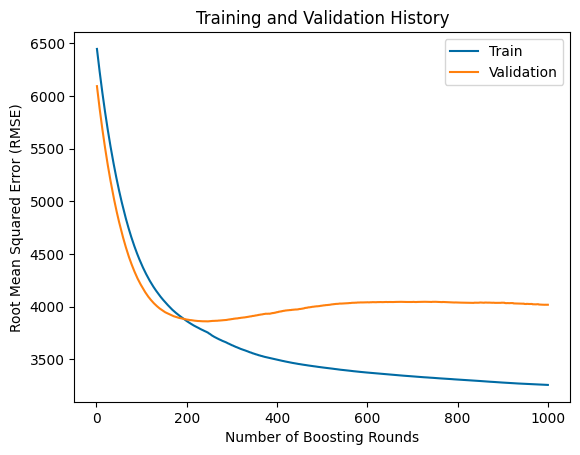

In [33]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

Este gráfico es útil para visualizar cómo cambian los errores de entrenamiento y validación a medida que avanza el entrenamiento del modelo. Vemos que hay overfitting porque el error de validacion empieza a aumentar pero el de train sigue bajando.

Entonces, cuando vemos overfitting, uno de los hiperparámetros clave que podemos ajustar es max_depth, que controla la profundidad máxima de cada árbol en el modelo.
queda pendiente para el alumno.


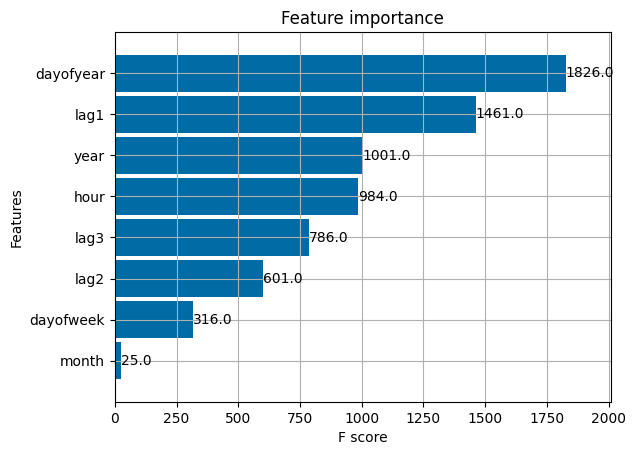

In [34]:
_ = plot_importance(reg, height=0.9)

**Pronostico sobre los datos de Test**

In [35]:
y_pred = reg.predict(X_val)

In [36]:
y_pred

array([29246.207, 28187.645, 27435.451, ..., 39445.77 , 36730.16 ,
       31657.69 ], dtype=float32)

Adicionamos la predicción al set de Validación

In [37]:
val['prediction'] = reg.predict(X_val)

<ipython-input-37-98263895fe04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


In [38]:
val['prediction']

,prediction
Datetime,
2017-08-03 01:00:00,29246.207031
2017-08-03 02:00:00,28187.644531
2017-08-03 03:00:00,27435.451172
2017-08-03 04:00:00,26743.353516
2017-08-03 05:00:00,26757.734375
...,...
2018-08-02 20:00:00,42574.808594
2018-08-02 21:00:00,41696.109375
2018-08-02 22:00:00,39445.769531


In [39]:
val

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction
Datetime,,,,,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,3,31,28809.0,29952.0,28465.0,29246.207031
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,3,31,27039.0,27934.0,26712.0,28187.644531
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,3,31,25881.0,26659.0,25547.0,27435.451172
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,3,31,25300.0,25846.0,24825.0,26743.353516
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,3,31,25412.0,25898.0,24927.0,26757.734375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,42574.808594
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,41696.109375
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,39445.769531


**Visualización de la predicción y los datos originales:**

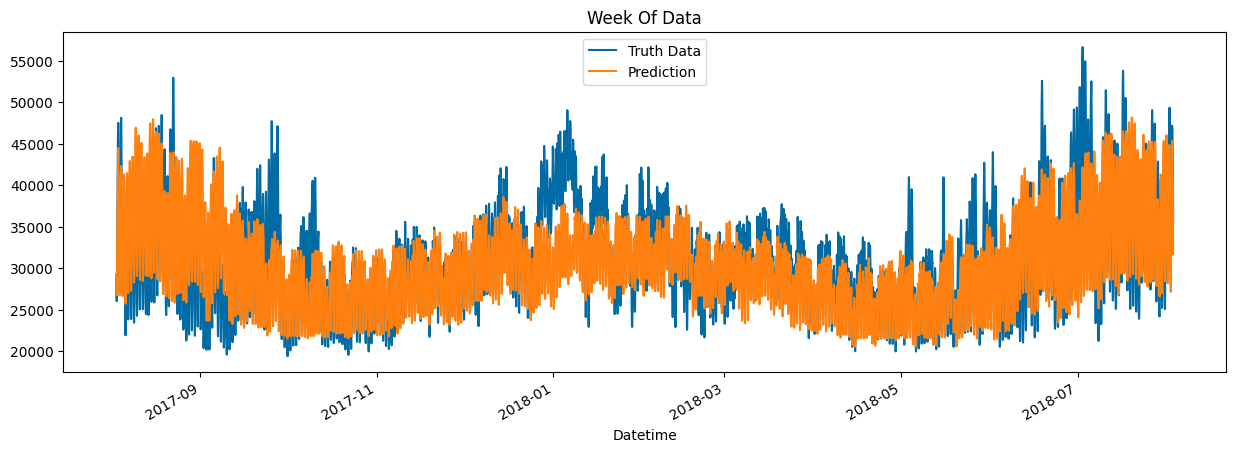

In [40]:
ax = val.loc[(val.index >= '2017-08-03')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

**Métricas de performance:**

In [41]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [42]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 16139541.147268416
Mean Absolute Error (MAE): 2946.9080287706906
RMSE Score on Test set: 4017.40
